---

## CoAVAREP Features

CoAVAREP is designed to extract features from audio signals, focusing on the acoustic aspects of speech.

### Modality
- **Type:** Audio
- **Purpose:**
  - Captures acoustic and paralinguistic characteristics (e.g., pitch, prosody, voice quality, spectral properties)

### Feature Extraction
- **Method:** Utilizes signal processing algorithms
- **Dimensionality:** Determined by the number of computed acoustic features (varies based on configuration)
- **Applications:**
  - Emotion Recognition
  - Speaker Identification
  - Voice Quality Assessment

---



### Importing Libraries

In [12]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import (
	Conv2D,
	MaxPooling2D,
	AveragePooling2D,
	Flatten,
	Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

### Loading Data Tensors

In [2]:
with open('../data/tensors.pkl', 'rb') as fr:
    data_tensors = pickle.load(fr)

### Prepare Data into Partitions that make sense

In [3]:
partitions_ = data_tensors[1]
data_all = data_tensors[0]
data_partitions = {partitions_[0]: data_all[0], partitions_[1]: data_all[1], partitions_[2]: data_all[2]}


In [4]:
data_partitions['train'].keys()

dict_keys(['COAVAREP', 'FACET 4.2', 'OpenFace_2.0', 'All Labels', 'glove_vectors', 'OpenSMILE'])

In [5]:
data_partitions['train']['COAVAREP'].shape

(16327, 50, 74)

### Exploring Training Data Distribution

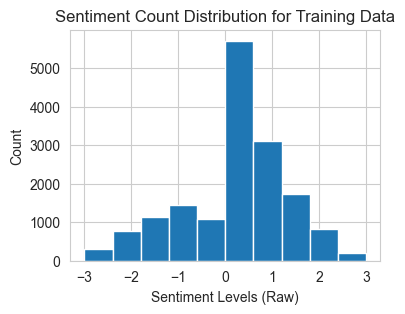

In [6]:
# looking at sentiment probability distribution in train
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(data_partitions['train']['All Labels'][:, :, 0])
ax.set_xlabel("Sentiment Levels (Raw)")
ax.set_ylabel("Count")
ax.set_title('Sentiment Count Distribution for Training Data')
plt.show()

### Extract COAVAREP Only

In [7]:
for k in data_partitions['train'].keys():
    if k == 'COAVAREP':
        X_train = data_partitions['train'][k]
        X_test = data_partitions['test'][k]
        X_val = data_partitions['valid'][k]
        print(f'{k} has dimension {X_train.shape[1:]}')

COAVAREP has dimension (50, 74)


### Preparing Labels for Training, Testing, and Validation

In [8]:
# Use continuous sentiment values for regression:
emo_selected = 0  # sentiment index
Y_train = data_partitions['train']['All Labels'][:, :, emo_selected]
Y_test = data_partitions['test']['All Labels'][:, :, emo_selected]
Y_val = data_partitions['valid']['All Labels'][:, :, emo_selected]

print(Y_train.shape, Y_test.shape, Y_val.shape)


(16327, 1) (4662, 1) (1871, 1)


### Building the CNN Model

In [9]:
input_dim_1 = X_train.shape[1]
input_dim_2 = X_train.shape[2]

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(input_dim_1, input_dim_2, 1)))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# Regression output layer: 1 neuron with linear activation
model.add(Dense(1, activation="linear"))

# Compile the model with a regression loss and metric
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])

/Users/alexanderhsu/Documents/GitHub/11777-EMOji/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Preparing Data for Model Training

In [10]:
# Reshape the data
X_train_reshape = X_train.reshape(-1, input_dim_1, input_dim_2, 1)
Y_train_reshape = np.array(Y_train).reshape(-1, 1)
X_test_reshape = X_test.reshape(-1, input_dim_1, input_dim_2, 1)
Y_test_reshape = np.array(Y_test).reshape(-1, 1)
X_val_reshape = X_val.reshape(-1, input_dim_1, input_dim_2, 1)
Y_val_reshape = np.array(Y_val).reshape(-1, 1)

# Handle potential Inf values in features
X_train_reshape[np.isinf(X_train_reshape)] = np.nan
X_train_reshape = np.nan_to_num(X_train_reshape, nan=np.nanmax(X_train_reshape))
X_test_reshape[np.isinf(X_test_reshape)] = np.nan
X_test_reshape = np.nan_to_num(X_test_reshape, nan=np.nanmax(X_test_reshape))
X_val_reshape[np.isinf(X_val_reshape)] = np.nan
X_val_reshape = np.nan_to_num(X_val_reshape, nan=np.nanmax(X_val_reshape))


### Training the Model

In [11]:
history = model.fit(X_train_reshape, 
                    Y_train_reshape, 
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val_reshape, Y_val_reshape),
                    verbose=2)

Epoch 1/200
511/511 - 17s - 34ms/step - loss: 1.2879 - mae: 0.8552 - val_loss: 1.1151 - val_mae: 0.8003
Epoch 2/200
511/511 - 17s - 32ms/step - loss: 1.2475 - mae: 0.8427 - val_loss: 1.0812 - val_mae: 0.7823
Epoch 3/200
511/511 - 17s - 32ms/step - loss: 1.2318 - mae: 0.8364 - val_loss: 1.0540 - val_mae: 0.7706
Epoch 4/200
511/511 - 17s - 32ms/step - loss: 1.2183 - mae: 0.8335 - val_loss: 1.0607 - val_mae: 0.7780
Epoch 5/200
511/511 - 17s - 33ms/step - loss: 1.2138 - mae: 0.8332 - val_loss: 1.0528 - val_mae: 0.7737
Epoch 6/200
511/511 - 17s - 32ms/step - loss: 1.2015 - mae: 0.8291 - val_loss: 1.0854 - val_mae: 0.7926
Epoch 7/200
511/511 - 17s - 33ms/step - loss: 1.1980 - mae: 0.8301 - val_loss: 1.0638 - val_mae: 0.7798
Epoch 8/200
511/511 - 17s - 33ms/step - loss: 1.1903 - mae: 0.8282 - val_loss: 1.0763 - val_mae: 0.7886
Epoch 9/200
511/511 - 17s - 33ms/step - loss: 1.1864 - mae: 0.8279 - val_loss: 1.0606 - val_mae: 0.7795
Epoch 10/200
511/511 - 17s - 32ms/step - loss: 1.1764 - mae: 0.8

In [13]:
# Save the entire model (architecture, weights, and optimizer state)
model.save("../models/coavarep_unimodal_baseline_regression_model.h5")

### Evaluating Model - Predictions and Metrics

In [14]:
# Predict on the test set
Y_pred = model.predict(X_test_reshape)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test_reshape, Y_pred)

# Compute Pearson correlation coefficient
# Flatten arrays in case they are multi-dimensional
corr, _ = pearsonr(Y_test_reshape.flatten(), Y_pred.flatten())

# Compute R-squared (Coefficient of Determination)
r2 = r2_score(Y_test_reshape, Y_pred)

print("MAE:", mae)
print("Correlation:", corr)
print("R2:", r2)

146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
MAE: 1.0915940999984741
Correlation: 0.1015298
R2: -0.552946925163269


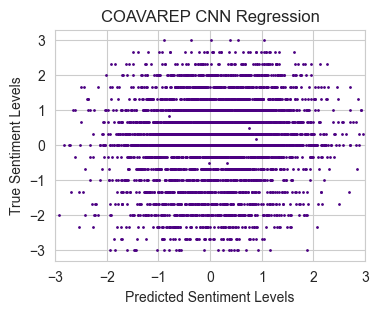

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(Y_pred, Y_test_reshape, s=1, color='indigo')
ax.set_xlabel("Predicted Sentiment Levels")
ax.set_ylabel("True Sentiment Levels")
ax.set_title('COAVAREP CNN Regression')
# clipping to possible sentiment to zoom in on within range predictions
ax.set_xlim([-3, 3])

plt.show()
fig.savefig('../figures/coavarep_baseline_regression_plot.png', bbox_inches='tight', dpi=300)